In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import numpy as np
import sigpy as sp
import sigpy.plot as pl
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import scikit_posthocs as sp


import sys
sys.path.append("/home/ahannum/Documents/Phase/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

In [2]:
import scipy.stats as st

# Code to Generate Metrics

In [3]:
def ci95(im):
    sort_im = np.sort(im,axis = (-1))
    lb_idx = round(sort_im.shape[-1]*0.05)
    lb = sort_im[:,:,lb_idx]
    ub_idx = round(sort_im.shape[-1]*0.95)
    ub = sort_im[:,:,ub_idx]
    med_im = np.nanmedian(sort_im,axis = -1)
    mean_im = np.nanmean(sort_im,axis = -1)
    std_im = np.nanstd(sort_im,axis = -1)

    return med_im,lb,ub,mean_im


    

# Load in Mask & Magnitude image
def get_metric_std(vv):
    print('starting',vv)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        mask_end.sort()
        mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
        mask = mask_end
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        if num ==0:
            M0_mask = mask
        if num ==1:
            M1_mask = mask
        if num ==2:
            M2_mask = mask


    savename = os.path.join(inpath,'M0_std_boostrap_bg.npy')
    M0_std = np.load(savename)
    
    savename = os.path.join(inpath,'M1_std_boostrap_bg.npy')
    M1_std = np.load(savename)

    savename = os.path.join(inpath,'M2_std_boostrap_bg.npy')
    M2_std = np.load(savename)

    med_m0 = np.zeros((128,128,6,4))
    lb_ub_m0 = np.zeros((2,128,128,6,4))
    mean_m0 = np.zeros((128,128,6,4))
    std_m0 = np.zeros((2,128,128,6,4))

    med_m1 = np.zeros((128,128,6,4))
    lb_ub_m1 = np.zeros((2,128,128,6,4))
    mean_m1 = np.zeros((128,128,6,4))
    std_m1 = np.zeros((2,128,128,6,4))

    med_m2 = np.zeros((128,128,6,4))
    lb_ub_m2 = np.zeros((2,128,128,6,4))
    mean_m2= np.zeros((128,128,6,4))
    std_m2 = np.zeros((2,128,128,6,4))

    for dd in range(4):
        for sl in range(6):
            ###############################################################################################
            im = (M0_std[:,:,sl,dd,:]) * M0_mask[:,:,sl][:,:,np.newaxis]
            med_m0[:,:,sl,dd], lb_ub_m0[0,:,:,sl,dd] ,lb_ub_m0[1,:,:,sl,dd],mean_m0[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M1_std[:,:,sl,dd,:]) * M1_mask[:,:,sl][:,:,np.newaxis]
            med_m1[:,:,sl,dd], lb_ub_m1[0,:,:,sl,dd] ,lb_ub_m1[1,:,:,sl,dd],mean_m1[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M2_std[:,:,sl,dd,:]) * M2_mask[:,:,sl][:,:,np.newaxis]
            med_m2[:,:,sl,dd], lb_ub_m2[0,:,:,sl,dd] ,lb_ub_m2[1,:,:,sl,dd],mean_m2[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

    
    savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m0, lb_ub = lb_ub_m0,avg = mean_m0)

    savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m1, lb_ub = lb_ub_m1,avg = mean_m1)

    savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m2, lb_ub = lb_ub_m2,avg = mean_m2)

    print('finished',vv)


   

In [4]:
# Difference metric 
import concurrent.futures
import logging
import threading
import time
import nibabel as nib

# Register all repetitions and directions together for either M0, M1, M2 all volunteers 
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(get_metric_std,num) for num in range(10)]
    for future in concurrent.futures.as_completed(futures):
        print(future.result())

starting 0
starting 1
starting 2


/home/ahannum/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
<ipython-input-3-b8bda07a1a2d>:8: RuntimeWarning: Mean of empty slice
  mean_im = np.nanmean(sort_im,axis = -1)
/home/ahannum/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


finished 2
starting 3
None
finished 1
starting 4
None
finished 0
starting 5
None


# Code to Display Metrics

In [4]:
from cmcrameri import cm
import seaborn as sns

In [5]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img>0] = 1
    edges_img.dtype = float
    edges_img[edges_img ==0] = 'nan'
    return edges_img

TD 6 Volunteer 6 sl 3


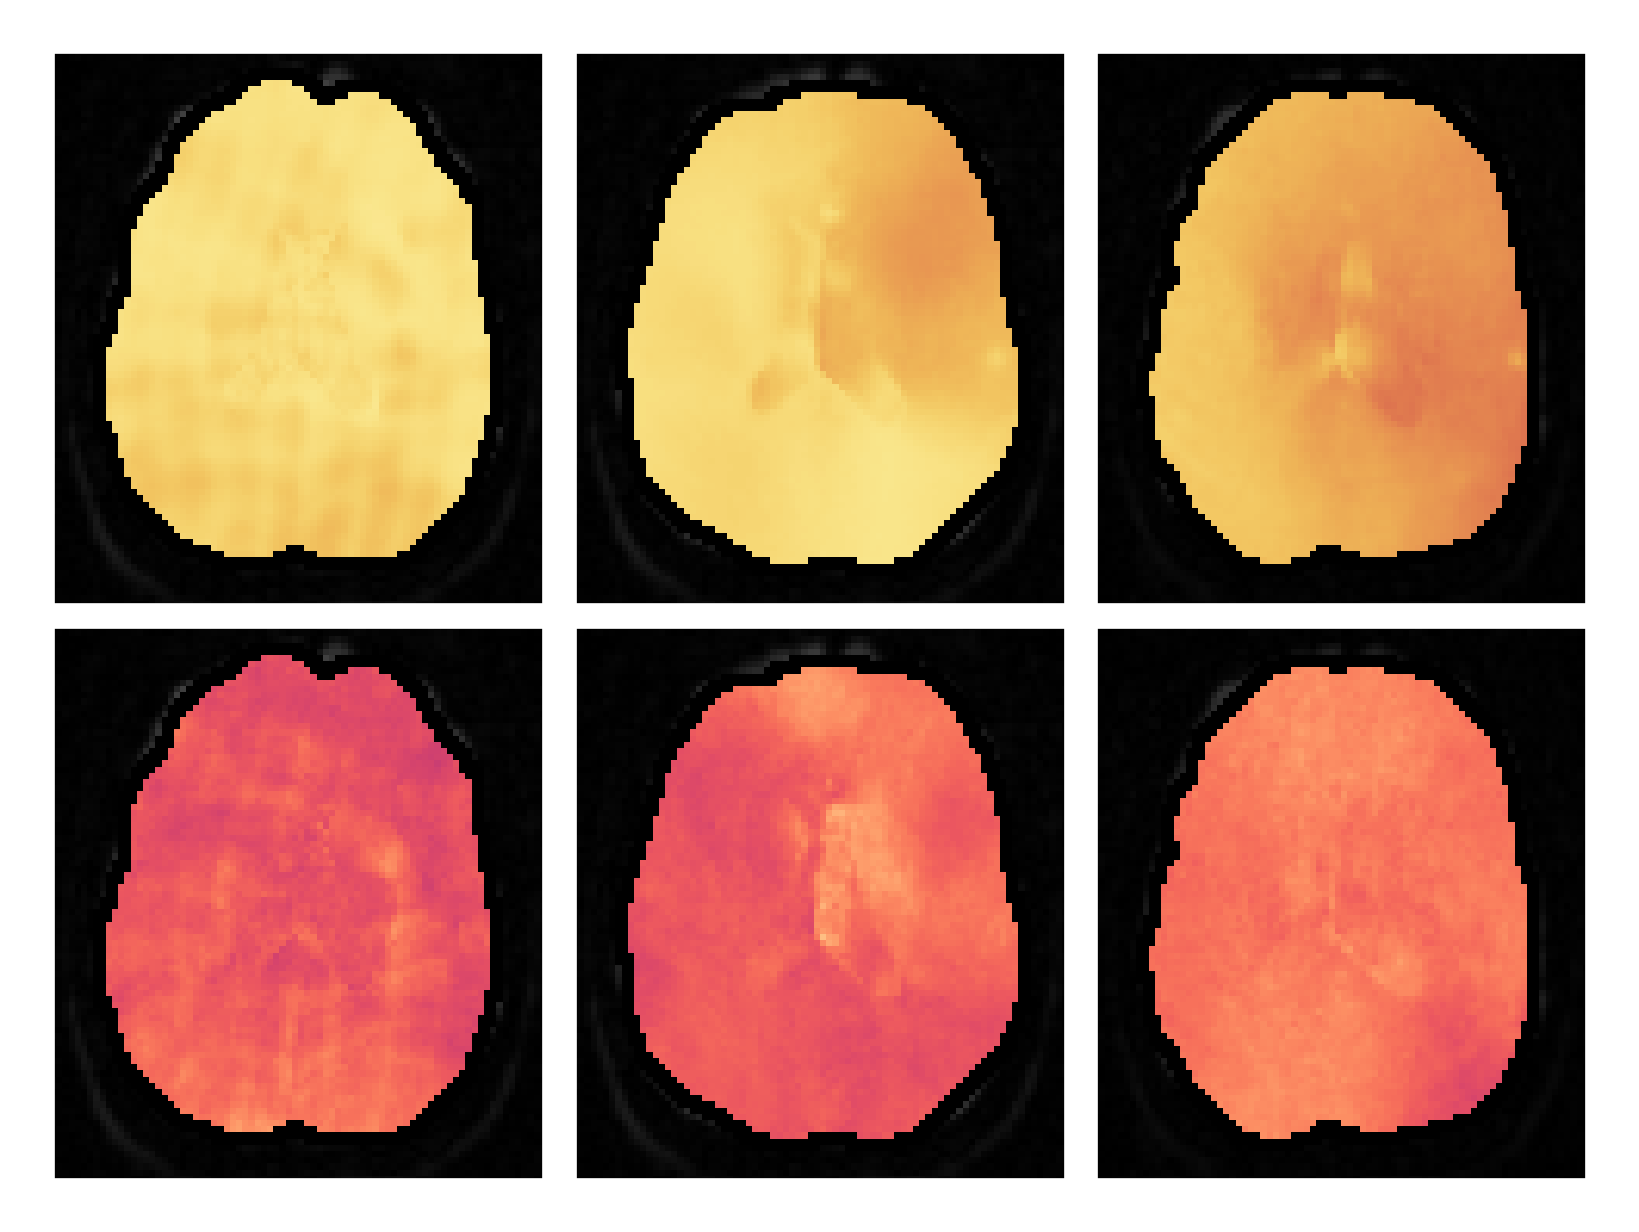

In [6]:
vv = 6
sl = 3
diffusion= 3

volunteers=[1,2,3,4,5,7,8,9,10,11]
volunteer = str(volunteers[vv])
inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 

savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
med_m0 = np.load(savename)['avg']
ci_m0 = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
med_m1 = np.load(savename)['avg']
ci_m1 = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
med_m2 = np.load(savename)['avg']
ci_m2 = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]



data,affine, voxsize = load_nifti(os.path.join(inpath, 'M0_registered_all.nii'), return_voxsize=True)
M0_mag = abs(data)
data,affine, voxsize = load_nifti(os.path.join(inpath, 'M1_registered_all.nii'), return_voxsize=True)
M1_mag = abs(data)
data,affine, voxsize = load_nifti(os.path.join(inpath, 'M2_registered_all.nii'), return_voxsize=True)
M2_mag = abs(data)




# Horizontal Fig 
td = vv

print('TD',td, 'Volunteer',vv,'sl',sl)
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(4,3), dpi=500)

w1 = 25
w2 = 115
l1= 25
l2 = 105

color = cm.lajolla_r
rep = 0

for ii in range(2):
    axes[ii,0].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 700,cmap = 'gray',interpolation = 'nearest')
    axes[ii,1].imshow(abs(M1_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 700,cmap = 'gray',interpolation = 'nearest')
    axes[ii,2].imshow(abs(M2_mag)[w1:w2,l1:l2,sl,diffusion,rep],vmin = 0,vmax = 700,cmap = 'gray',interpolation = 'nearest')
    



######### STandard Deviation 
phs_m0 = (med_m0) #* M0_mask[:,:,:,diffusion,0,:]
phs_m1 = (med_m1) #* M1_mask[:,:,:,diffusion,0,:]
phs_m2 = (med_m2) #* M2_mask[:,:,:,diffusion,0,:] 
axes[0,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[0,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im2=axes[0,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')


color = sns.color_palette("magma",as_cmap = True)
######### STandard Deviation 
phs_m0 = (ci_m0) #* M0_mask[:,:,:,diffusion,0,:]
phs_m1 = (ci_m1) #* M1_mask[:,:,:,diffusion,0,:]
phs_m2 = (ci_m2) #* M2_mask[:,:,:,diffusion,0,:] 
axes[1,0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
axes[1,1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
im2=axes[1,2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')

phse_m0 = np.where(np.isnan(phs_m0)==False)
for ii in range(2):
    axes[ii,0].imshow(get_edge((np.isnan(phs_m0)==False)[w1:w2,l1:l2,sl,diffusion]),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[ii,1].imshow(get_edge((np.isnan(phs_m1)==False)[w1:w2,l1:l2,sl,diffusion]),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[ii,2].imshow(get_edge((np.isnan(phs_m2)==False)[w1:w2,l1:l2,sl,diffusion]),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



for m in range(2):
    for j in range(3):
        axes[m,j].get_xaxis().set_ticks([])
        axes[m,j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.03, hspace=0.03)   
plt.show()

In [7]:
med_m0 = np.zeros((128,128,6,4,10))
med_m1 = np.zeros((128,128,6,4,10))
med_m2 = np.zeros((128,128,6,4,10))


ci_m0 = np.zeros((128,128,6,4,10))
ci_m1 = np.zeros((128,128,6,4,10))
ci_m2 = np.zeros((128,128,6,4,10))
for vv in range(10):

    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 

    savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
    med_m0[:,:,:,:,vv] = np.load(savename)['med']
    ci_m0[:,:,:,:,vv]  = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

    savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
    med_m1[:,:,:,:,vv] = np.load(savename)['med']
    ci_m1[:,:,:,:,vv]  = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]

    savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
    med_m2[:,:,:,:,vv] = np.load(savename)['med']
    ci_m2[:,:,:,:,vv]  = np.load(savename)['lb_ub'][1,:,:,:,:,] - np.load(savename)['lb_ub'][0,:,:,:,:,]




In [8]:
import pandas as pd
med_m0_med = np.nanmean(med_m0,axis = (0,1))
med_m1_med = np.nanmean(med_m1,axis = (0,1))
med_m2_med = np.nanmean(med_m2,axis = (0,1))

med_stack = np.stack((med_m0_med,med_m1_med,med_m2_med),axis = -1)
print(med_stack.shape)

import pandas as pd
ci_m0_med = np.nanmean(ci_m0,axis = (0,1))
ci_m1_med = np.nanmean(ci_m1,axis = (0,1))
ci_m2_med = np.nanmean(ci_m2,axis = (0,1))

ci_stack = np.stack((ci_m0_med,ci_m1_med,ci_m2_med),axis = -1)

(6, 4, 10, 3)


In [9]:
data.shape

(128, 128, 6, 4, 40)

/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categori

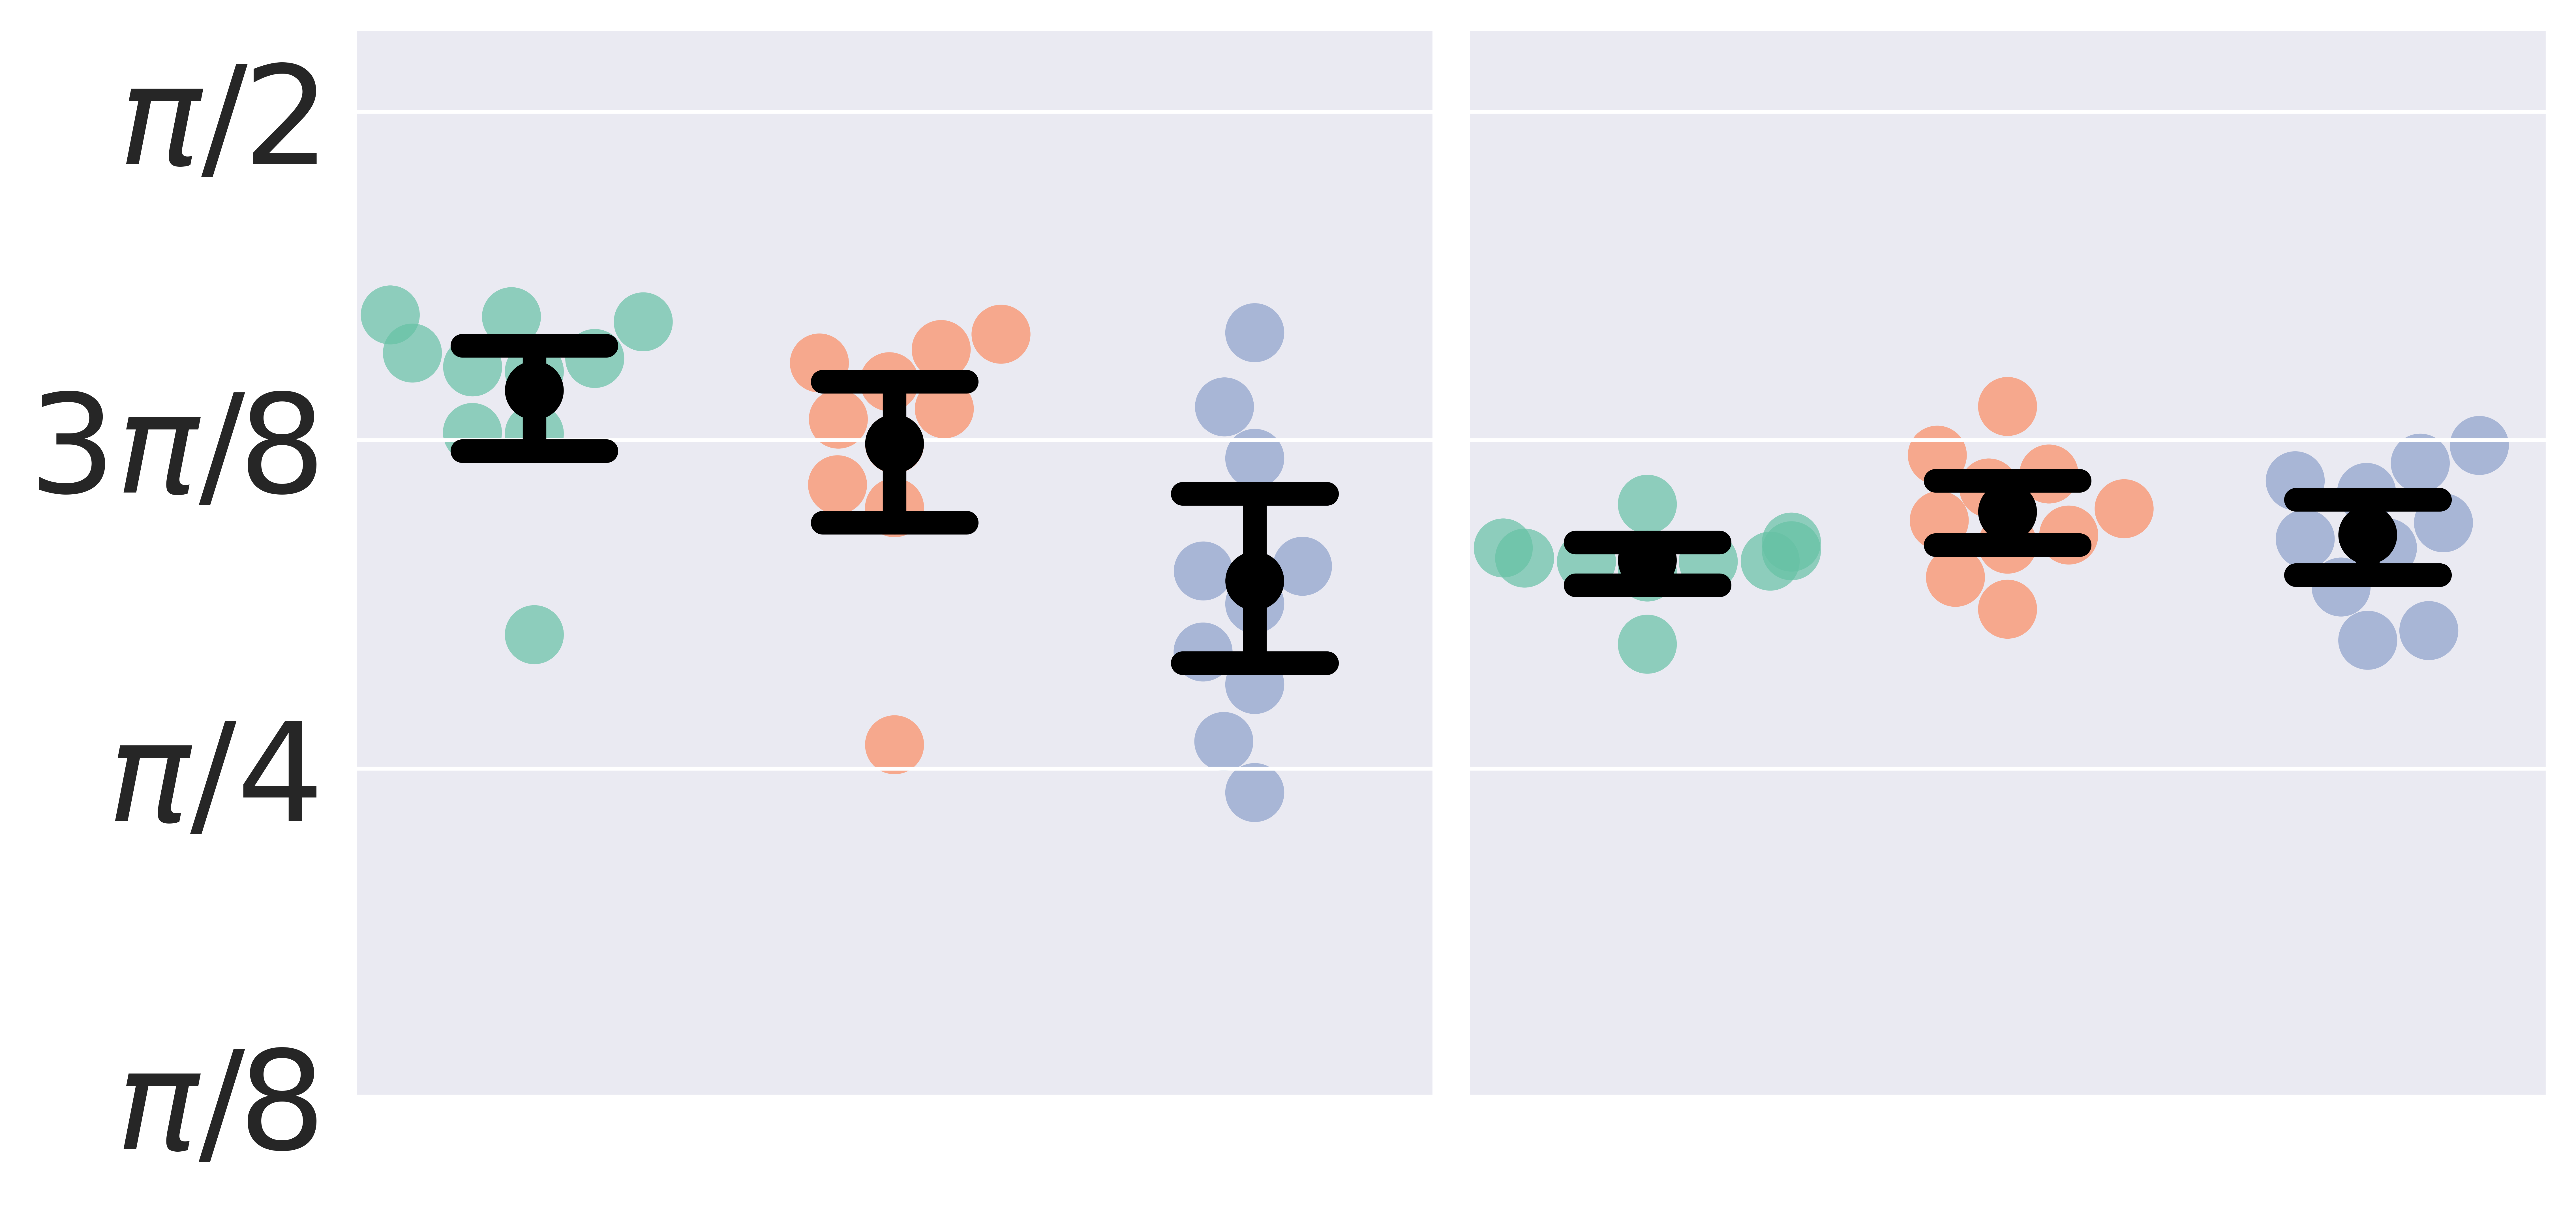

In [10]:

dd = -1
sl = 3



fig, axes = plt.subplots(1, 2, figsize=(10,5),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [0,1,2]


for ii in range(2):
    axes[ii].set_xticks([0,1,2])
    axes[ii].set_xticklabels(['1','2','3'],size = 1,color='white')
    axes[ii].tick_params(axis='y', which='major', labelsize=35)
    axes[ii].tick_params(axis='x', which='major', labelsize=35)
    axes[ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
    axes[ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 35,rotation = 0)
    axes[ii].set_ylim([math.pi/8,math.pi/2+0.1])
    axes[ii].set_xlim([-0.2,2.2])
    axes[ii].set_xticks([0,1,2])
    axes[ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
            

data = pd.DataFrame(med_stack[sl,dd,:,:])
sns.swarmplot(data=data,color = 'black',
    size = 15,zorder = 0,edgecolor='gray', ax = axes[0],palette='Set2',alpha = 0.7)


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7, #errorbar=("se",np.nanstd(data,-1)),
    capsize=.4, join=False, orient ='v',ax=axes[0],
)


data = pd.DataFrame(ci_stack[sl,dd,:,:])
sns.swarmplot(data=data,color = 'black',ax = axes[1],
    size = 15,zorder = 0,edgecolor='gray', palette='Set2',alpha = 0.7)


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7,#errorbar=("se",data),
    capsize=.4, join=False, orient ='v',ax=axes[1],
)

plt.subplots_adjust(wspace=0.03, hspace=0.03)   
plt.show()



In [11]:

dd = 1
sl = 2



fig, axes = plt.subplots(3, 2, figsize=(10,15),sharex=True,sharey = True,dpi=1000)
count = 0
slices= [4,3,1]


for dd in range(3,4):
    for sl in range(3):
        for ii in range(2):
            axes[sl,ii].set_xticks([0,1,2])
            axes[sl,ii].set_xticklabels(['1','2','3'],size = 1,color='white')
            axes[sl,ii].tick_params(axis='y', which='major', labelsize=35)
            axes[sl,ii].tick_params(axis='x', which='major', labelsize=35)
            axes[sl,ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
            axes[sl,ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
            axes[sl,ii].set_ylim([math.pi/8-0.1,math.pi/2+0.1])
            axes[sl,ii].set_xlim([-0.2,2.2])
            axes[sl,ii].set_xticks([0,1,2])
            axes[sl,ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
                
        data = pd.DataFrame(med_stack[slices[sl],dd,:,:])
        sns.swarmplot(data=data,color = 'black',
            size = 15,zorder = 0,edgecolor='gray', ax = axes[sl,0],palette='Set2',alpha = 0.7)

        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, #errorbar=("se",np.nanstd(data,-1)),
            capsize=.4, join=False, orient ='v',ax=axes[sl,0],
        )

        data = pd.DataFrame(ci_stack[slices[sl],dd,:,:])
        sns.swarmplot(data=data,color = 'black',
            size = 15,zorder = 0,edgecolor='gray', ax = axes[sl,1],palette='Set2',alpha = 0.7)

        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, #errorbar=("se",np.nanstd(data,-1)),
            capsize=.4, join=False, orient ='v',ax=axes[sl,1],
        )


plt.subplots_adjust(wspace=0.05, hspace=0.03)  
plt.show()





/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categori

In [12]:

dd = 1
sl = 2



fig, axes = plt.subplots(3, 2, figsize=(10,15),sharex=True,sharey = True,dpi=1000)
count = 0
slices= [5,4,3,2,1,0]


for dd in range(3):
    for sl in range(3,4):
        for ii in range(2):
            axes[dd,ii].set_xticks([0,1,2])
            axes[dd,ii].set_xticklabels(['1','2','3'],size = 1,color='white')
            axes[dd,ii].tick_params(axis='y', which='major', labelsize=35)
            axes[dd,ii].tick_params(axis='x', which='major', labelsize=35)
            axes[dd,ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
            axes[dd,ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
            axes[dd,ii].set_ylim([0,3*math.pi/8+0.1])
            axes[dd,ii].set_xlim([-0.2,2.2])
            axes[dd,ii].set_xticks([0,1,2])
            axes[dd,ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)


        data = pd.DataFrame(med_stack[sl,dd,:,:])
        sns.stripplot(data=data,color = 'black',
            size = 15,zorder = 0,edgecolor='gray', ax = axes[dd,0],palette='Set2',alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, #errorbar=("se",np.nanstd(data,-1)),
            capsize=.4, join=False, orient ='v',ax=axes[dd,0],
        )


        data = pd.DataFrame(ci_stack[sl,dd,:,:])
        sns.stripplot(data=data,color = 'black',
            size = 15,zorder = 0,edgecolor='gray', ax = axes[dd,1],palette='Set2',alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7, #errorbar=("se",np.nanstd(data,-1)),
            capsize=.4, join=False, orient ='v',ax=axes[dd,1],
        )


plt.subplots_adjust(wspace=0.05, hspace=0.03)  
plt.show()





/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


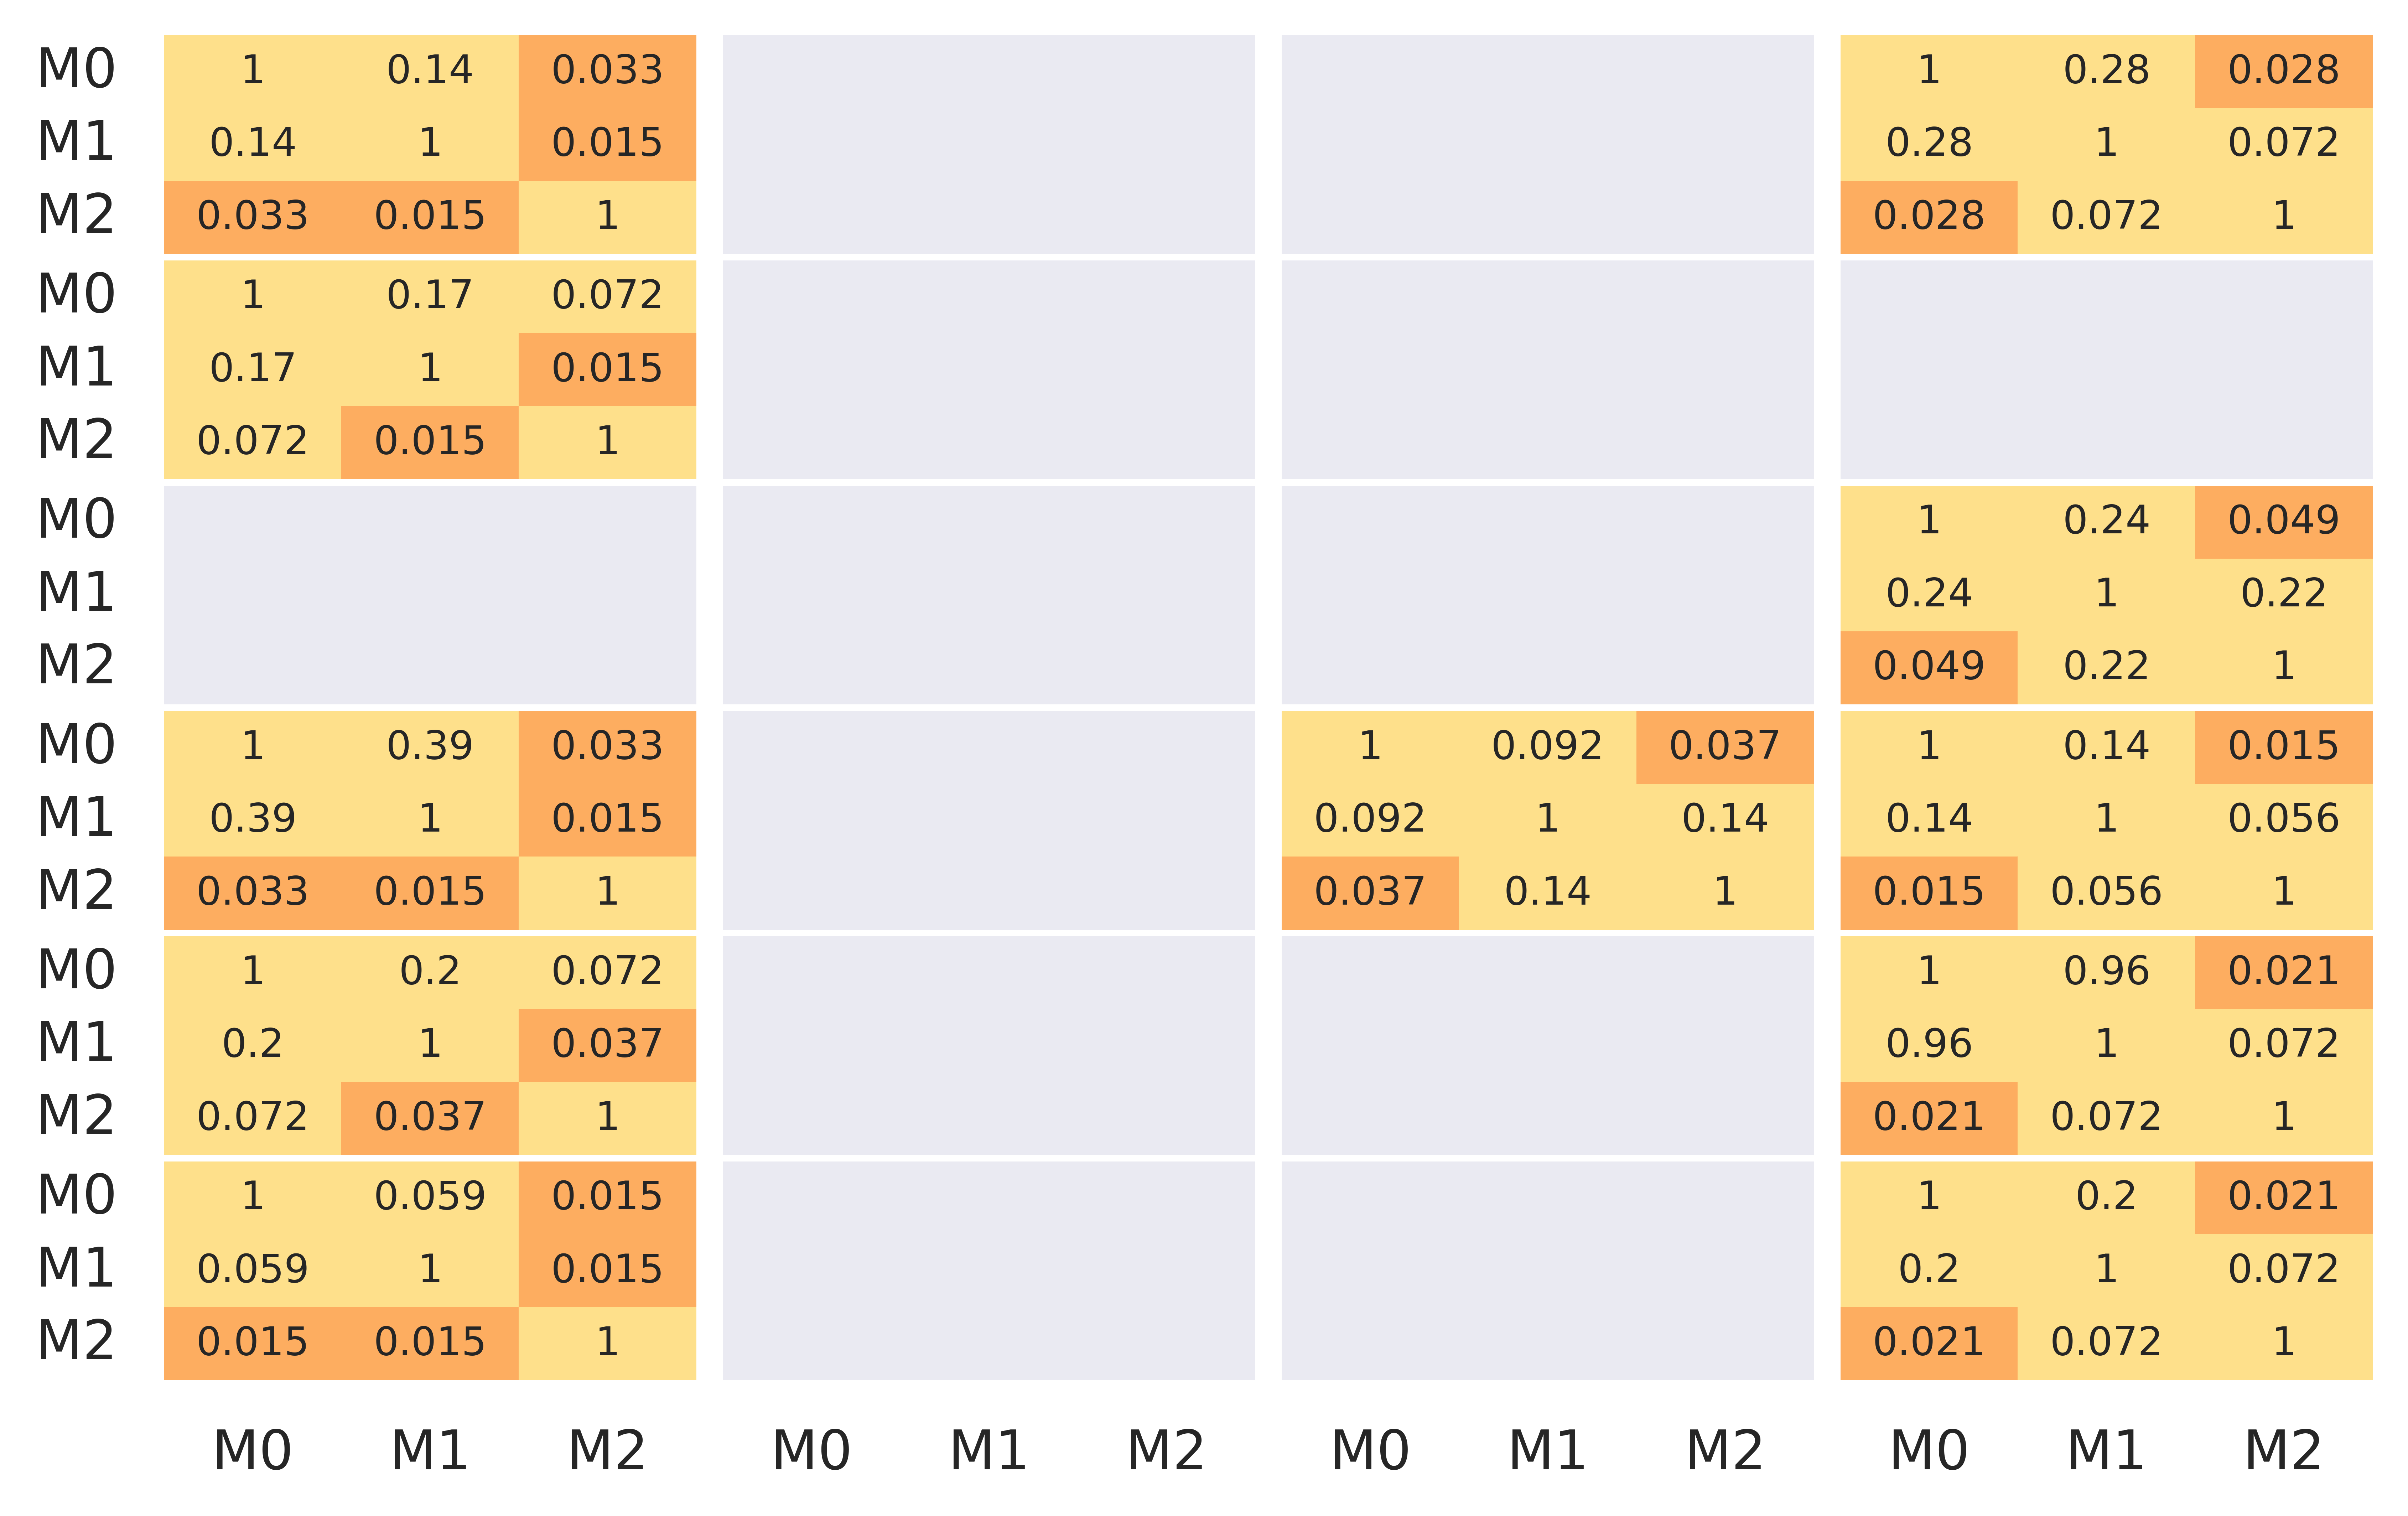

In [13]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((6,4,3,3))
hypothesis[:] = np.nan

slices = [5,4,3,2,1,0]
for sl in range(6):
    for dd in range(4):
        group1 = med_stack[slices[sl],dd,:,0]
        group2 = med_stack[slices[sl],dd,:,1]
        group3 = med_stack[slices[sl],dd,:,2]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(6, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(6):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




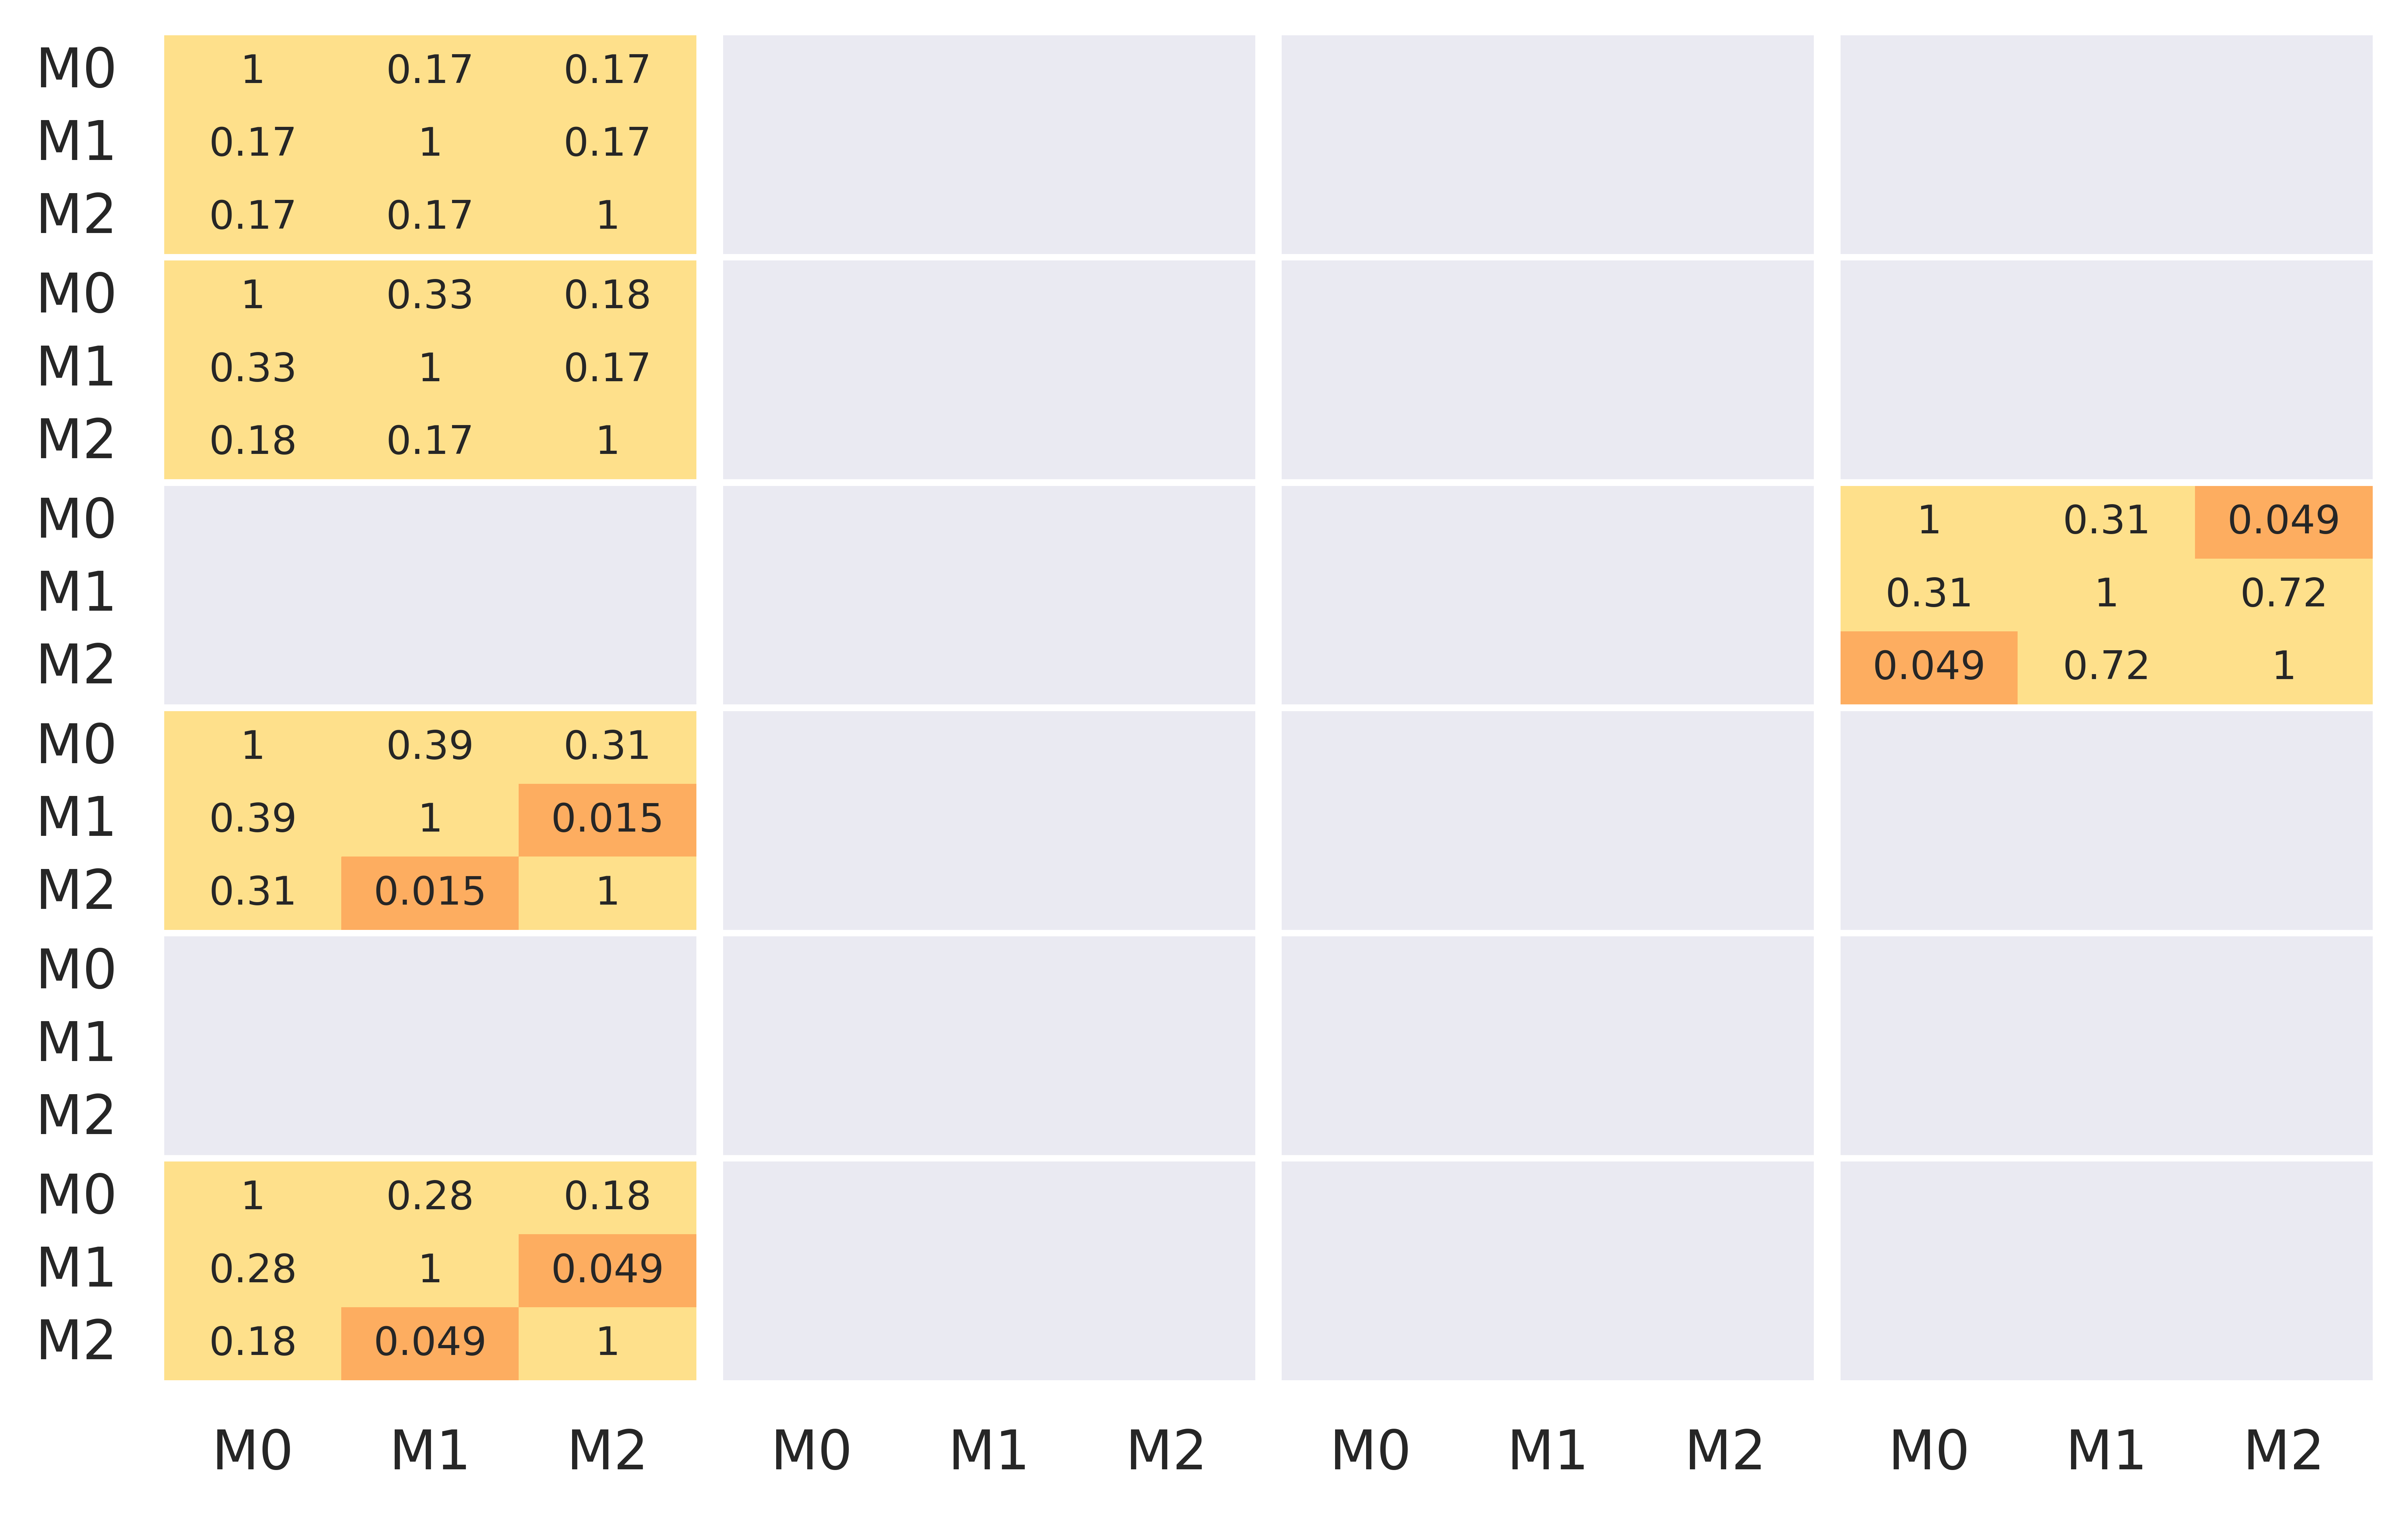

In [14]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((6,4,3,3))
hypothesis[:] = np.nan

slices = [5,4,3,2,1,0]
for sl in range(6):
    for dd in range(4):
        group1 = ci_stack[slices[sl],dd,:,0]
        group2 = ci_stack[slices[sl],dd,:,1]
        group3 = ci_stack[slices[sl],dd,:,2]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(6, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(6):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


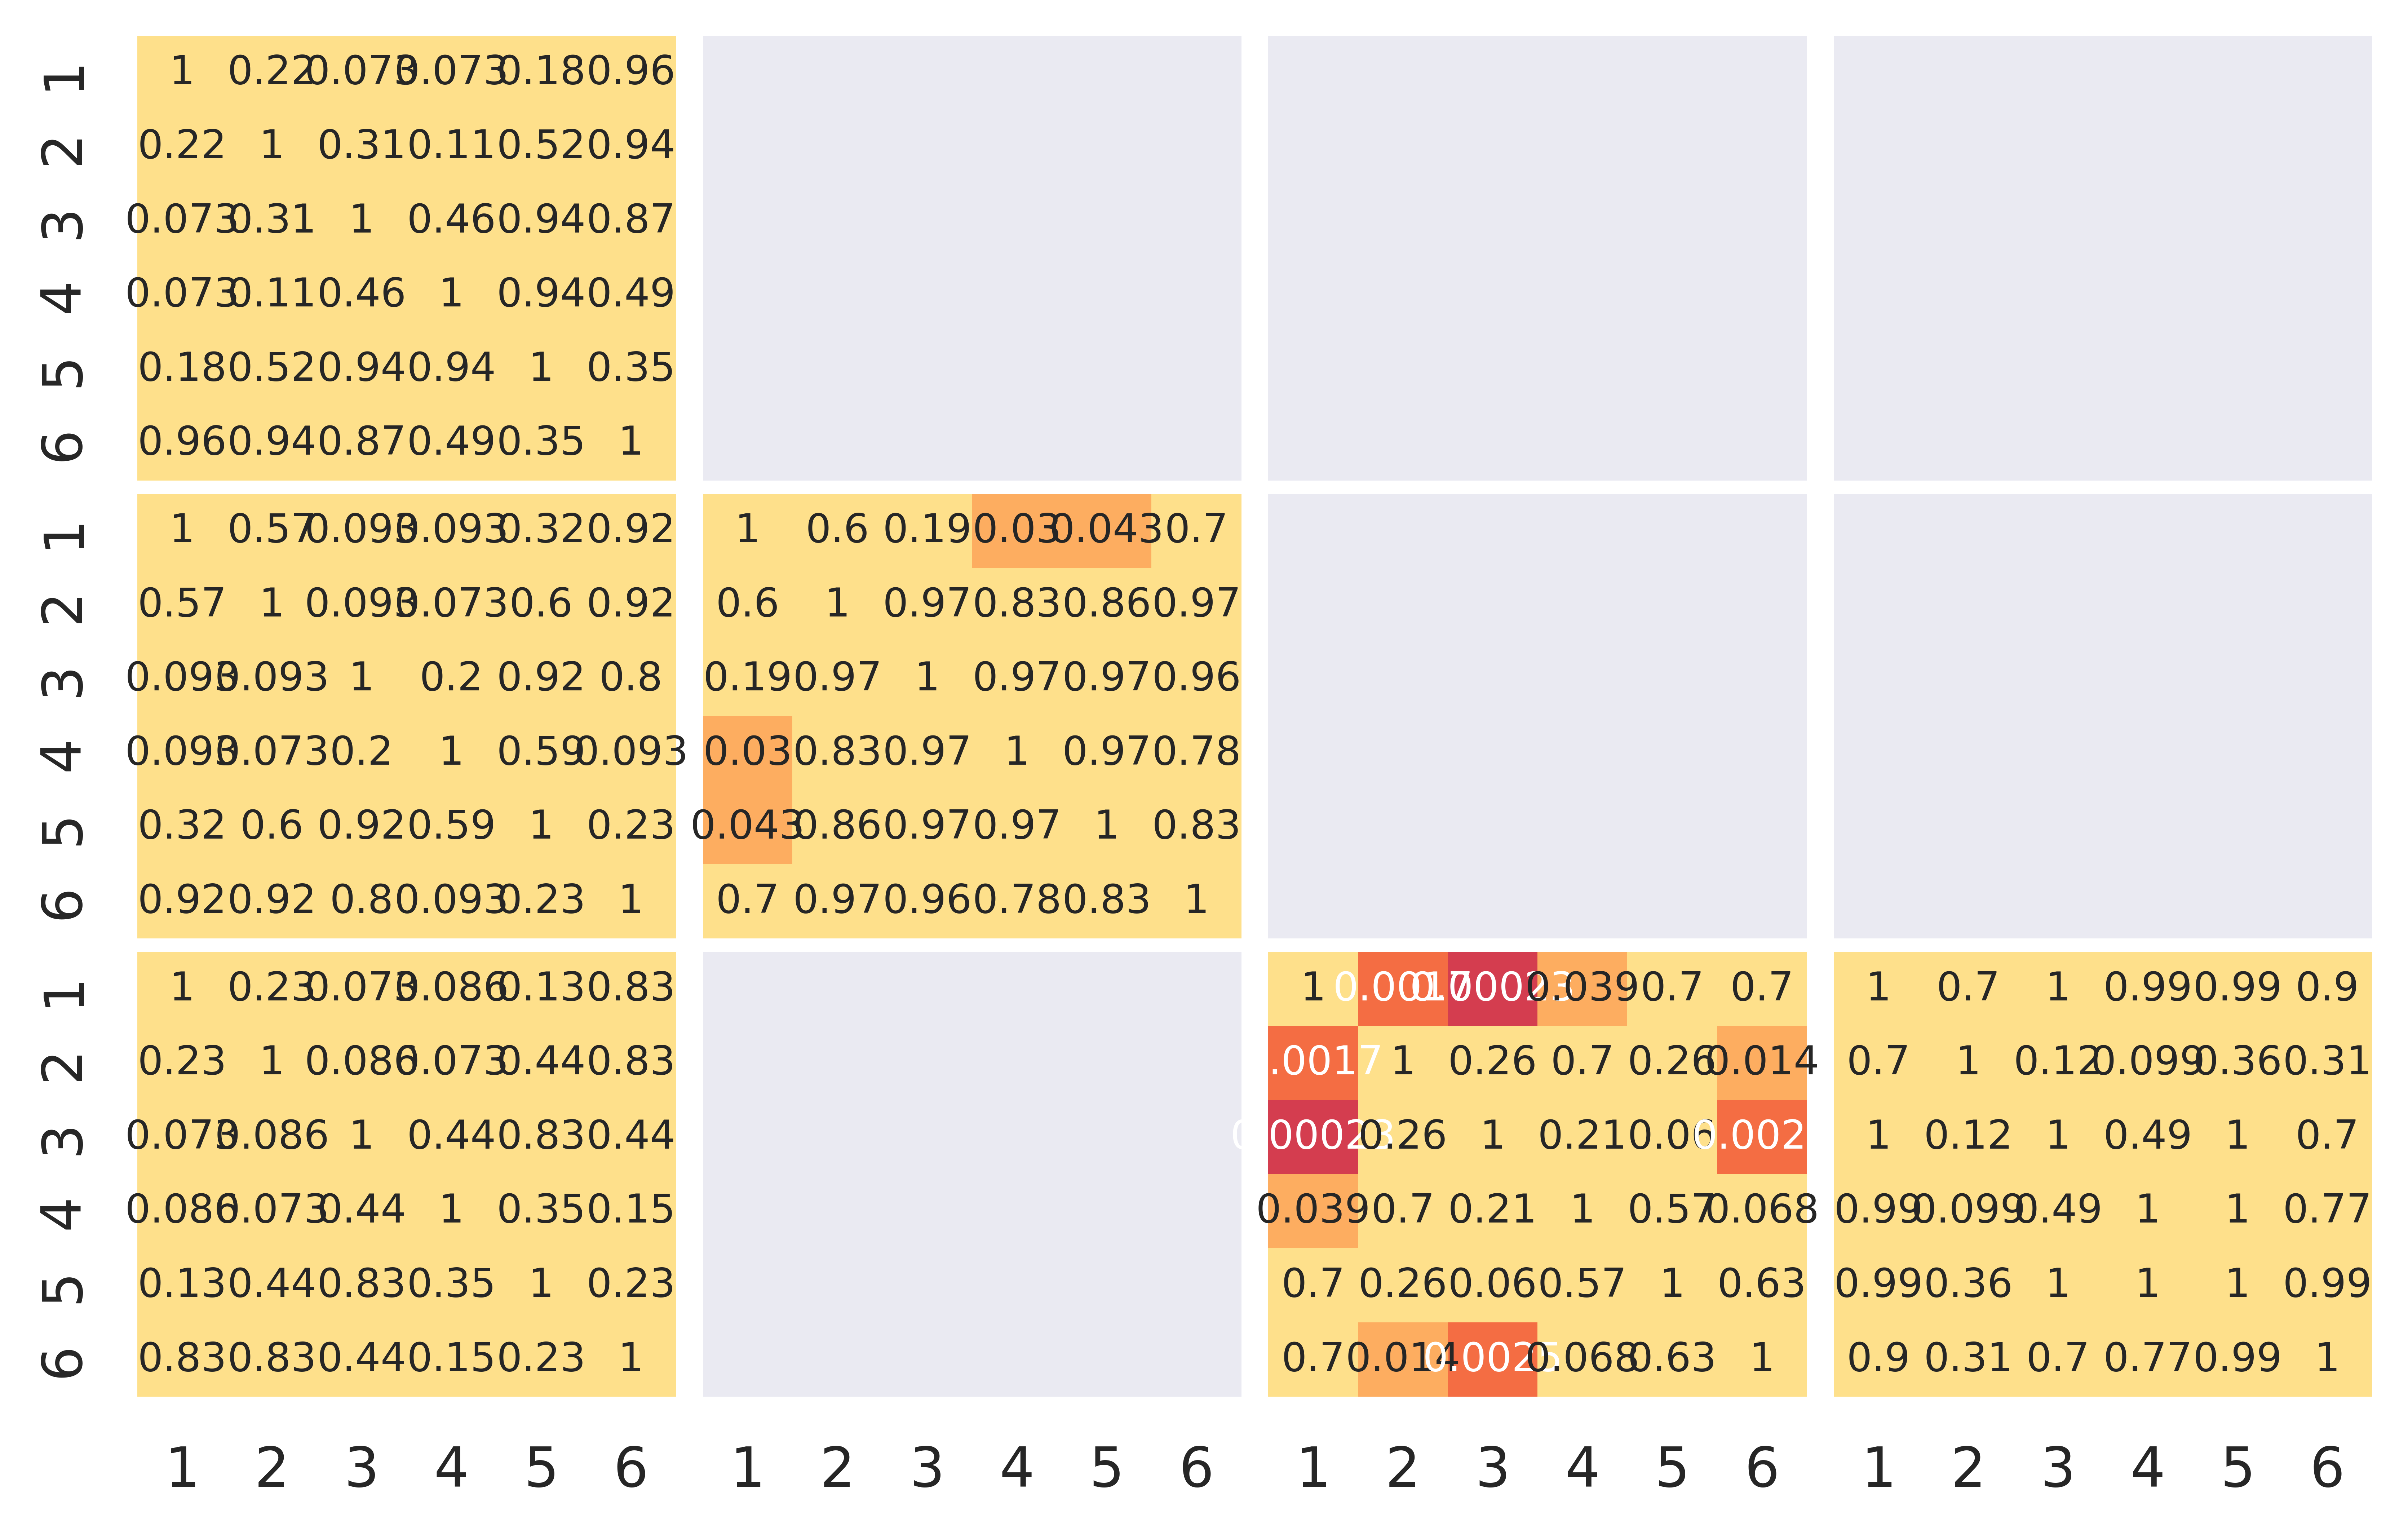

In [15]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((3,4,6,6))
hypothesis[:] = np.nan

slices = [5,4,3,2,1,0]
for sl in range(3): #motion
    for dd in range(4):
        group1 = med_stack[0,dd,:,sl]
        group2 = med_stack[1,dd,:,sl]
        group3 = med_stack[2,dd,:,sl]
        group4 = med_stack[3,dd,:,sl]
        group5 = med_stack[4,dd,:,sl]
        group6 = med_stack[5,dd,:,sl]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3,group4,group5,group6],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3,group4,group5,group6],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(3, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(3):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=[1,2,3,4,5,6],
                    yticklabels=[1,2,3,4,5,6],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)


